In [1]:
%pip install davos
import davos

davos.config.suppress_stdout = True

Note: you may need to restart the kernel to use updated packages.


In [2]:
smuggle datawrangler as dw        # pip: pydata-wrangler==0.2.2

smuggle numpy as np               # pip: numpy==1.24.2
smuggle matplotlib.pyplot as plt  # pip: matplotlib==3.7.0
smuggle pandas as pd              # pip: pandas==1.5.3
smuggle seaborn as sns            # pip: seaborn==0.12.2
from scipy.stats import ttest_1samp, ttest_rel  # pip: scipy==1.10.1

from tqdm smuggle tqdm            # pip: tqdm==4.64.1

smuggle requests                  # pip: requests==2.28.2

from glob import glob as lsdir
import os
import pickle
import json

In [3]:
basedir = os.path.split(os.getcwd())[0]
datadir = os.path.join(basedir, 'data')
figdir = os.path.join(basedir, 'paper', 'figs', 'source')

if not os.path.exists(figdir):
    os.makedirs(figdir)

In [21]:
def parse_behavioral_data(datadir):
    def get_pres_time(image, stim_type, log):
        if type(image) is str:
            image_times = log.loc[log['Info'].apply(lambda x: (image in x) and (stim_type in x) if type(x) is str else False)]
            assert image_times.shape[0] == 4, Exception(f'Image {image} appears the wrong number of times')
            return image_times.iloc[-2]['Time'], image_times.iloc[-1]['Time']
        else:
            return np.nan, np.nan
        
    def add_timing_info(subj_df):
        def timing_helper(x, log):
            image = np.nan
            stim_type = ''
            if image is np.nan:
                image = x['Cued Composite']
                stim_type = 'CUED COMPOSITE'
            if image is np.nan:
                image = x['Memory Image']
                stim_type = 'MEMORY IMAGE'
            
            return get_pres_time(image, stim_type, log)
        
        result = []
        runs = np.unique(subj_df['Run'])
        for i in runs:
            log = pd.read_csv(os.path.join(datadir, subj_df['Subject'].values[0], f'-{i}.log'), delimiter='\t', header=None, names=['Time', 'Event', 'Info'])
            x = subj_df.query('Run == @i').copy()

            next_times = x.apply(lambda y: timing_helper(y, log), axis=1)

            x['Stimulus Onset'] = [t[0] for t in next_times]
            x['Stimulus Offset'] = [t[1] for t in next_times]

            result.append(x.drop('Stimulus End', axis=1))
        return pd.concat(result, ignore_index=True)

    def helper(subjdir):
        subj = os.path.basename(subjdir)

        pres_fnames = lsdir(os.path.join(subjdir, 'pres*.csv'))
        mem_fnames = lsdir(os.path.join(subjdir, 'mem*.csv'))

        pres = pd.concat([pd.read_csv(fname) for fname in pres_fnames], ignore_index=True)
        mem = pd.concat([pd.read_csv(fname) for fname in mem_fnames], ignore_index=True)
        
        df = pd.concat([pres, mem], ignore_index=True).sort_values(['Run']).drop('Unnamed: 0', axis=1)
        df['Subject'] = subj
        df = add_timing_info(df)
        return df

    subjdirs = lsdir(os.path.join(datadir, '*_20??_*_*'))
    return pd.concat([helper(subjdir) for subjdir in subjdirs], ignore_index=True)

In [22]:
sustained_behavioral = parse_behavioral_data(os.path.join(datadir, 'sustained'))
variable_behavioral = parse_behavioral_data(os.path.join(datadir, 'variable'))

notes:
- for behavioral data parsing, update stimulus timing to add in the "current time" at the beginning of each logfile
- for gaze parsing, convert human readable time stamps into unix times that are compatable with behavioral logs
- to save space: remove all gaze data outside of the range of each participant's log files for each run
- save a "parsed" version of the full dataset that can be either downloaded from dropbox (if large) or saved on github (if small)

In [23]:
sustained_behavioral

,Subject,Trial Type,Run,Cued Composite,Uncued Composite,Cued Face,Cued Place,Uncued Face,Uncued Place,Memory Image,...,Familiarity Rating,Attention Level,Cue Validity,Post Invalid Cue,Pre Invalid Cue,Attention Button,Rating History,Stimulus Onset,Attention Probe,Stimulus Offset
0,34_2019_Oct_13,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,00753941201fa.jpg,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,128.7374,NaN,130.723
1,34_2019_Oct_13,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,00754941201fa.jpg,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,164.8195,NaN,166.8323
2,34_2019_Oct_13,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,00779941205fa.jpg,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,161.8178,NaN,163.819
3,34_2019_Oct_13,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,sunafbwnojpqeyzssoe.jpg,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,158.8175,NaN,160.8127
4,34_2019_Oct_13,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,sunaaeplwsfslcbtojr.jpg,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,155.7993,NaN,157.8119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,9_2019_Oct_14,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,sunajtrfunvzdfticna.jpg,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,128.6934,NaN,130.7049
11996,9_2019_Oct_14,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,sunagdzlvkqtpnfxfcg.jpg,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,125.6907,NaN,127.6945
11997,9_2019_Oct_14,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,sunayaepykrqvenaqqy.jpg,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,122.6751,NaN,124.686
11998,9_2019_Oct_14,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,00754941201fa.jpg,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,143.7142,NaN,145.7263


In [24]:
variable_behavioral

,Subject,Trial Type,Run,Cued Composite,Uncued Composite,Cued Face,Cued Place,Uncued Face,Uncued Place,Memory Image,...,Familiarity Rating,Attention Level,Cue Validity,Post Invalid Cue,Pre Invalid Cue,Attention Button,Rating History,Stimulus Onset,Attention Probe,Stimulus Offset
0,56_2020_Feb_21,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,00720960620fa.jpg,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,115.4129,NaN,117.4121
1,56_2020_Feb_21,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,sunagufzbeteqdjxais.jpg,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,151.5218,NaN,153.5217
2,56_2020_Feb_21,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,sunaecpkgfewqqreqwe.jpg,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,148.5044,NaN,150.5158
3,56_2020_Feb_21,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,00146960620fb.jpg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145.5038,NaN,147.5032
4,56_2020_Feb_21,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,sunbpflsdaxnddnwcqi.jpg,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,142.4862,NaN,144.5009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9195,0_2020_Feb_07,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,00062931230fb.jpg,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,158.3669,NaN,160.3787
9196,0_2020_Feb_07,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,00198940128fb.jpg,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,155.3658,NaN,157.3622
9197,0_2020_Feb_07,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,00184940128fa.jpg,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,152.3487,NaN,154.3605
9198,0_2020_Feb_07,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,sunabcuurugvxwparpk.jpg,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,173.435,NaN,175.4383


In [30]:
np.max([x for x in sustained_behavioral['Stimulus Onset'] if type(x) is float])

246.1054

In [25]:
sustained_behavioral.query("`Trial Type` == 'Presentation'")

,Subject,Trial Type,Run,Cued Composite,Uncued Composite,Cued Face,Cued Place,Uncued Face,Uncued Place,Memory Image,...,Familiarity Rating,Attention Level,Cue Validity,Post Invalid Cue,Pre Invalid Cue,Attention Button,Rating History,Stimulus Onset,Attention Probe,Stimulus Offset
40,34_2019_Oct_13,Presentation,0,00070940307fa_sunaaeplwsfslcbtojr.jpg,00631940928fa_sunadbdqzigzwipuipr.jpg,00070940307fa.jpg,sunaaeplwsfslcbtojr.jpg,00631940928fa.jpg,sunadbdqzigzwipuipr.jpg,NaN,...,NaN,NaN,1.0,NaN,NaN,3.0,NaN,12.3693,x,15.384
41,34_2019_Oct_13,Presentation,0,00874940307fa_sunajtrfunvzdfticna.jpg,00959960627fa_sunavxokzybtomhbmvm.jpg,00874940307fa.jpg,sunajtrfunvzdfticna.jpg,00959960627fa.jpg,sunavxokzybtomhbmvm.jpg,NaN,...,NaN,NaN,1.0,NaN,NaN,3.0,NaN,55.7837,x,58.7984
42,34_2019_Oct_13,Presentation,0,00548940519fa_sunacerqowiaeoqkmsq.jpg,00766960620fa_sunafijbgncijwykrnl.jpg,00548940519fa.jpg,sunacerqowiaeoqkmsq.jpg,00766960620fa.jpg,sunafijbgncijwykrnl.jpg,NaN,...,NaN,NaN,1.0,NaN,NaN,3.0,NaN,46.0803,x,49.0948
43,34_2019_Oct_13,Presentation,0,00482940519fa_sunabyfxcxhdebvdyfd.jpg,00127931230fa_sunaampvucecsfbdafn.jpg,00482940519fa.jpg,sunabyfxcxhdebvdyfd.jpg,00127931230fa.jpg,sunaampvucecsfbdafn.jpg,NaN,...,NaN,NaN,1.0,NaN,NaN,1.0,NaN,41.0789,o,44.0934
44,34_2019_Oct_13,Presentation,0,00109931230fa_sunaajuzribjrizdshh.jpg,00725941201fa_sunaefgzwiramypjvtd.jpg,00109931230fa.jpg,sunaajuzribjrizdshh.jpg,00725941201fa.jpg,sunaefgzwiramypjvtd.jpg,NaN,...,NaN,NaN,1.0,NaN,NaN,3.0,NaN,36.5945,x,39.6084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11955,9_2019_Oct_14,Presentation,7,00125931230fa_sunaalltyvjhbzhkmvg.jpg,00752960620fa_sunafbwnojpqeyzssoe.jpg,00125931230fa.jpg,sunaalltyvjhbzhkmvg.jpg,00752960620fa.jpg,sunafbwnojpqeyzssoe.jpg,NaN,...,NaN,NaN,1.0,NaN,NaN,1.0,NaN,32.8114,x,35.8257
11956,9_2019_Oct_14,Presentation,7,00133931230fa_sunaanlwnpqndclffxt.jpg,00908960530fa_sunanwjjyqqwzqrqagd.jpg,00133931230fa.jpg,sunaanlwnpqndclffxt.jpg,00908960530fa.jpg,sunanwjjyqqwzqrqagd.jpg,NaN,...,NaN,NaN,1.0,NaN,NaN,1.0,NaN,42.5311,x,45.5452
11957,9_2019_Oct_14,Presentation,7,00761960627fa_sunafgdqbclkwfocdhg.jpg,00818940307fa_sunahpblecxtmuzkmxb.jpg,00761960627fa.jpg,sunafgdqbclkwfocdhg.jpg,00818940307fa.jpg,sunahpblecxtmuzkmxb.jpg,NaN,...,NaN,NaN,1.0,NaN,NaN,1.0,NaN,47.4163,x,50.4305
11958,9_2019_Oct_14,Presentation,7,00305940422fa_sunabtrnbvpppgczjim.jpg,00568940928fa_sunacsdhbbsybcyxnel.jpg,00305940422fa.jpg,sunabtrnbvpppgczjim.jpg,00568940928fa.jpg,sunacsdhbbsybcyxnel.jpg,NaN,...,NaN,NaN,0.0,NaN,NaN,3.0,NaN,13.3884,o,16.4027


In [26]:
sustained_behavioral.query("`Trial Type` == 'Memory'")

,Subject,Trial Type,Run,Cued Composite,Uncued Composite,Cued Face,Cued Place,Uncued Face,Uncued Place,Memory Image,...,Familiarity Rating,Attention Level,Cue Validity,Post Invalid Cue,Pre Invalid Cue,Attention Button,Rating History,Stimulus Onset,Attention Probe,Stimulus Offset
0,34_2019_Oct_13,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,00753941201fa.jpg,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,128.7374,NaN,130.723
1,34_2019_Oct_13,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,00754941201fa.jpg,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,164.8195,NaN,166.8323
2,34_2019_Oct_13,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,00779941205fa.jpg,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,161.8178,NaN,163.819
3,34_2019_Oct_13,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,sunafbwnojpqeyzssoe.jpg,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,158.8175,NaN,160.8127
4,34_2019_Oct_13,Memory,0,NaN,NaN,NaN,NaN,NaN,NaN,sunaaeplwsfslcbtojr.jpg,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,155.7993,NaN,157.8119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,9_2019_Oct_14,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,sunajtrfunvzdfticna.jpg,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,128.6934,NaN,130.7049
11996,9_2019_Oct_14,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,sunagdzlvkqtpnfxfcg.jpg,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,125.6907,NaN,127.6945
11997,9_2019_Oct_14,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,sunayaepykrqvenaqqy.jpg,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,122.6751,NaN,124.686
11998,9_2019_Oct_14,Memory,7,NaN,NaN,NaN,NaN,NaN,NaN,00754941201fa.jpg,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,143.7142,NaN,145.7263


In [27]:
def parse_gaze_data(subjdir):
    def multi_get(d, keys):
        if type(d) is list:
            x = [multi_get(i, keys) for i in d]
            return pd.DataFrame.from_dict(x, dtype=float)

        if type(keys) is dict:
            return {k: multi_get(d, v) for k, v in keys.items()}

        vals = []
        for k in keys:
            if type(k) is list:
                vals.append(multi_get(d, k))
            elif k in d:
                d = d[k]
            else:
                return np.nan
        if len(vals) == 0:
            return d
        else:
            try:
                return np.nanmean(vals)
            except:
                return vals
    
    gaze_dict = {'time': ['values', 'frame', 'timestamp'],
             'x': ['values', 'frame', 'avg', 'x'],
             'y': ['values', 'frame', 'avg', 'y'],
            'pupil size': [['values', 'frame', 'lefteye', 'psize'], ['values', 'frame', 'righteye', 'psize']]}
    
    def helper(subjdir):
        subj = os.path.basename(subjdir)

        gaze_data_files = lsdir(os.path.join(subjdir, 'eye_data', '*_*'))
        gaze_data = []
        for g in gaze_data_files:
            with open(g, 'r') as f:
                content = f.readlines()
                data = [json.loads(line) for line in content]
            
            df = multi_get(data, gaze_dict)
            df['Subject'] = subj
            df['Run'] = int(os.path.basename(g).split('_')[1])

            # convert x and y values to cm
            

    
            gaze_data.append(df)

        return pd.concat(gaze_data, axis=1, ignore_index=True)

    return pd.concat([helper(s) for s in subjdirs], ignore_index=True)

In [9]:
subjdirs = lsdir(os.path.join(datadir, 'sustained', '*_20??_*_*'))

In [14]:
fname = os.path.join(subjdirs[0], 'eye_data', '34_0')

In [35]:
with open(fname, 'r') as f:
    content = f.readlines()
    data = [json.loads(line) for line in content]

In [40]:
pd.DataFrame.from_dict(data[0]).reset_index().drop(['index'], axis=1)

,category,request,statuscode,values
0,tracker,get,200,"{'avg': {'x': 1213.6536, 'y': 421.1285}, 'fix'..."


In [51]:
pd.DataFrame.from_dict(pd.DataFrame.from_dict(data[0]['values']).loc['lefteye'].values[0])

,avg,pcenter,psize,raw
x,1317.1237,0.4308,17.7087,1314.4279
y,484.3337,0.5213,17.7087,486.4987


In [53]:
np.unique([x['category'] for x in data])

array(['heartbeat', 'tracker'], dtype='<U9')

In [57]:
np.unique([x['state'] for x in data if 'statuscode' in x])

array([200])

In [60]:
gaze_info = pd.Series(index=['time', 'x', 'y', 'pupil size'], dtype=float)
gaze_info

time         NaN
x            NaN
y            NaN
pupil size   NaN
dtype: float64

In [64]:
multi_get(data[0], ['values', 'frame', 'avg', 'x'])

88107374

In [74]:
multi_get(data[0], [['values', 'frame', 'lefteye', 'avg', 'x'], ['values', 'frame', 'righteye', 'avg', 'x']])

1183.5464000000002

In [78]:
multi_get(data[0], ['values', 'frame', 'righteye', 'psize'])

16.6201

In [92]:
gaze_dict = {'time': ['values', 'frame', 'time'],
             'x': ['values', 'frame', 'avg', 'x'],
             'y': ['values', 'frame', 'avg', 'y'],
            'pupil size': [['values', 'frame', 'lefteye', 'psize'], ['values', 'frame', 'righteye', 'psize']]}

gaze_data = multi_get(data, gaze_dict)


/var/folders/tp/qtzc39jx5w556wl5w3dj21wr0000gn/T/ipykernel_6332/1975333754.py:21: RuntimeWarning: Mean of empty slice
  return np.nanmean(vals)


In [90]:
gaze_data

,time,x,y,pupil size
0,88107374.0,1213.6536,421.1285,17.1644
1,88107407.0,1206.0886,416.8463,16.9355
2,88107441.0,1187.4131,409.2379,17.15045
3,88107485.0,1186.7231,415.5982,17.0422
4,88107517.0,1169.3149,404.8496,16.9604
...,...,...,...,...
10257,88485172.0,914.3013,643.0429,18.3292
10258,88485206.0,908.9858,638.4476,18.57675
10259,88485240.0,906.0461,636.8060,18.3784
10260,88485274.0,906.1965,636.6711,18.4328


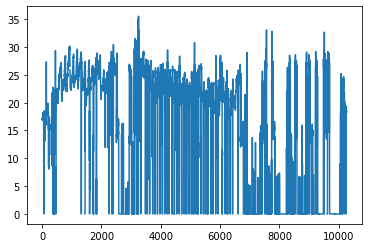

In [93]:
plt.plot(gaze_data['pupil size'])

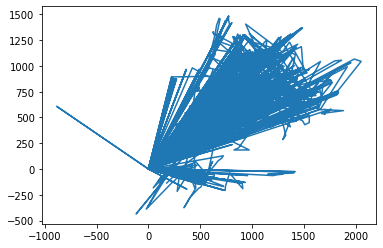

In [95]:
plt.plot(gaze_data['x'], gaze_data['y'])

In [58]:
data[1]

{'category': 'tracker',
 'request': 'get',
 'statuscode': 200,
 'values': {'frame': {'avg': {'x': 1206.0886, 'y': 416.8463},
   'fix': False,
   'lefteye': {'avg': {'x': 1306.1493, 'y': 472.9652},
    'pcenter': {'x': 0.4309, 'y': 0.5213},
    'psize': 17.351,
    'raw': {'x': 1306.1493, 'y': 472.9652}},
   'raw': {'x': 1180.9553, 'y': 407.574},
   'righteye': {'avg': {'x': 1055.7615, 'y': 342.1828},
    'pcenter': {'x': 0.5793, 'y': 0.5138},
    'psize': 16.52,
    'raw': {'x': 1055.7615, 'y': 342.1828}},
   'state': 7,
   'time': 88107407,
   'timestamp': '2019-10-13 09:13:15.919'}}}

In [32]:
y = json.loads(x)

JSONDecodeError: Extra data: line 3 column 1 (char 489)

{'category': 'tracker',
 'request': 'get',
 'statuscode': 200,
 'values': {'frame': {'avg': {'x': 1213.6536, 'y': 421.1285},
   'fix': False,
   'lefteye': {'avg': {'x': 1317.1237, 'y': 484.3337},
    'pcenter': {'x': 0.4308, 'y': 0.5213},
    'psize': 17.7087,
    'raw': {'x': 1314.4279, 'y': 486.4987}},
   'raw': {'x': 1178.4822, 'y': 408.4915},
   'righteye': {'avg': {'x': 1049.9691, 'y': 323.2373},
    'pcenter': {'x': 0.5791, 'y': 0.5137},
    'psize': 16.6201,
    'raw': {'x': 1042.5365, 'y': 330.4843}},
   'state': 7,
   'time': 88107374,
   'timestamp': '2019-10-13 09:13:15.886'}}}